In [46]:
#импорт библиотек
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools

In [315]:
#функции, используемые при обращении оператора производной Фреше в решаемых задачах

def right1(x, Psi, D2Psi,params):
    eps = params[0]
    gamma = params[1]
    V = params[2]
    return z1(x, params)-G(x, Psi, D2Psi, params)-(eps**2)*D2Psi
def g(x ,Psi, D2Psi,params):
    """
    функция g(x) (Задача 2) 
    """
    eps = params[0]
    gamma = params[1]
    V = params[2]
    return -np.cosh(Psi)/np.sinh(V)


def z0(x,params):
    """
    вид функции концентрации примеси для тестирования точности алогритма 
    """
    eps = params[0]
    gamma = params[1]
    V = params[2]
    return -V * (eps**2) * 2.0 * (gamma**2)*np.tanh(gamma*x)/np.tanh(gamma)/((np.cosh(gamma*x))**2)+np.sinh(V*np.tanh(gamma*x)/np.tanh(gamma))/np.sinh(V)


def z2(x, params):
    """
    функция концентрации примеси 
    """
    if (x< 0):
        return -(-x*x-x+1)
    elif x==0:
        return 0
    else:
        return -(x*x-x-1)

def z3(x, params):
    """
    функция концентрации примеси 
    """
    if (x< 0):
        return -(0.1*np.sin(2*np.pi*x)+1)
    elif x==0:
        return 0
    else:
        return -(-0.1*np.sin(2*np.pi*x)-1)   
    
def z1(x, params):
    """
    функция концентрации примеси 
    """
    if (x< 0):
        return -1
    elif x==0:
        return 0
    else:
        return 1
def G(x, Psi, D2Psi, params):
    """
    функция G(x) (Задача 2) 
    """
    eps = params[0]
    gamma = params[1]
    V = params[2]
    return np.sinh(Psi)/np.sinh(V)

def leftlin(x, Psi, D2Psi, fk, gk, params):
    """
    Выражения из левой части
    системы в Задаче 3
    """
    eps = params[0]
    gamma = params[1]
    V = params[2]
    rez = -fk*np.exp(-Psi)-gk*np.exp(Psi)
    return rez

def right2(x, Psi, D2Psi, fk, gk, params):
    """
    Правая часть системы в Задаче 3
    """
    eps = params[0]
    gamma = params[1]
    V = params[2]
    rez = -fk*np.exp(-Psi)+gk*np.exp(Psi) + z3(x,params)- (eps**2)*D2Psi
    return rez

In [186]:
#вспомогоательные функции, используемые при заполнении матрицы при аппрокисмации второй производной
def ddstepmn(X, n):
    """
    коэффициенты матрицы, возникающие при аппроксимации
    второй производной по n точкам
    """
    l = len(X)
    A = np.empty(l)
    for i in range(l):
        A[i] = 1
        for j in range(l):
            if (j != i):
                A[i] *= (X[i]-X[j])
    s = np.empty(l)
    
    ls = list(itertools.combinations(np.arange(l), l-3))
    sm = np.zeros(l)
    for i in range(l):
        s[i] = 1
    for i in range(l):
        for elem in ls:
            presum = 1
            for t in range(len(elem)):
                if (elem[t] != n-1 and elem[t] != i):
                    presum *= (X[n-1] - X[elem[t]])
                else:
                    presum *= 0
                    #print('er')
            sm[i] += presum

        s[i] *= sm[i] * 2 / A[i]
    return s

def ddstepm(X, F, n):
    """
    вторая производная функции в точке, вычисляемая по n точкам
    """
    l = len(X)
    A = np.empty(l)
    for i in range(l):
        A[i] = 1
        for j in range(l):
            if (j != i):
                A[i] *= (X[i]-X[j])
    s = np.empty(l)
    #print("A", A)
    
    ls = list(itertools.combinations(np.arange(l), l-3))
    sm = np.zeros(l)
    for i in range(l):
        s[i] = 1
    for i in range(l):
        for elem in ls:
            presum = 1
            for t in range(len(elem)):

                if (elem[t] != n-1 and elem[t] != i):
                    presum *= (X[n-1] - X[elem[t]])
                else:
                    presum *= 0

            sm[i] += presum

        s[i] *= sm[i] * 2 / A[i] * F[i]
    ss = 0
    for z in range(l):
        ss+= s[z]
    return ss

In [51]:
#вычисление первой проивзодной по n точкам
def dstepm(X, F, n):
    """
    первая производная функции в точке,
    вычисляемая по n точкам
    """
    l = len(X)
    A = np.empty(l)
    for i in range(l):
        A[i] = 1
        for j in range(l):
            if (j != i):
                A[i] *= (X[i]-X[j])
    s = np.empty(l)
    #print("A", A)
    
    ls = list(itertools.combinations(np.arange(l), l-2))
    sm = np.zeros(l)
    for i in range(l):
        s[i] = 1
    for i in range(l):
        for elem in ls:
            presum = 1
            for t in range(len(elem)):

                if (elem[t] != n-1 and elem[t] != i):
                    presum *= (X[n-1] - X[elem[t]])
                else:
                    presum *= 0

            sm[i] += presum

        s[i] *= sm[i] / A[i] * F[i]
    ss = 0
    for z in range(l):
        ss+= s[z]
    return ss

In [ ]:
#решение СЛАУ с помощью Numpy
def cgalg(A, f):
    x = np.linalg.solve(A,f)
    return x

In [52]:
def Step1(grid, psi, dpsi, params, n):
    """
    Обращение оператора производной Фреше
    в задаче при условии малых токов
    """
    eps = params[0]
    gamma = params[1]
    V = params[2]
    s = len(psi)
    F = np.empty(s-2)
    M = np.zeros((s-2,s-2), dtype = np.float64)
    for i in range(1, s-1):
        F[i-1]= right1(grid[i], psi[i], dpsi[i], params)   
    for i in range(1, int(n/2)+1):
        args = ddstepmn(grid[i-1:i+2], 2)
        for j in range(0,3):
            if((i-2+j)>=0):
                M[i-1][i-2+j] = pow(eps, 2)* args[j]
        M[i-1][i-1] -= g(grid[i], psi[i], dpsi[i], params)
    for i in range(int(n/2) +1, s-(int(n/2)+1)):
        args = ddstepmn(grid[i-int(n/2):i+(int(n/2) +1)],int(n/2) +1)
        for j in range(n):
            M[i-1][j+i-(int(n/2)+1)] = args[j]* pow(eps,2)
        M[i-1][i-1] -= g(grid[i], psi[i], dpsi[i], params)
    M[0][s-3]=0
    for i in range(1, int(n/2)+1):
        args = ddstepmn(grid[s-1-(i+3):s-1-(i)], 2)
        for j in range(0,3):
            if((s-2-i+j-1)<=s-3):
                M[s-2-i][s-2-i+j-1] = pow(eps, 2)* args[j]
        M[s-2-i][s-2-i] -= g(grid[s-i-1], psi[s-i-1], dpsi[s-i-1], params)      
    temp = cgalg(M, F)
    rez = np.append(0.0,temp)
    rez = np.append(rez, 0.0)
    return rez

In [53]:
###### взятие производной на сетке по n точкам
def DDerivm(x, F, n):
    """
    Взятие второй производной,
    вычисляемой по n точкам, от всей функции
    """
    s = len(x)
    fd = np.empty(s)
    for i in range(0, int(n/2)):
        fd[i] =  ddstepm(x[0:n], F[0:n], i+1)
    for i in range(int(n/2), s-int(n/2)):        
        xx = x[i-int(n/2):i+int(n/2)+1]
        FFf= F[i-int(n/2):i+int(n/2)+1]    
        fd[i] = ddstepm(xx, FFf, int(n/2)+1)        
    for i in range(s-int(n/2), s):
        fd[i] = ddstepm(x[s-n:s], F[s-n:s], n-(s-i)+1) 
    return fd

In [54]:
def Derivm(x, F, n):
    """
    Взятие второй производной,
    вычисляемой по n точкам, от всей функции
    """
    s = len(x)
    fd = np.empty(s)
    for i in range(0, int(n/2)):
        fd[i] =  dstepm(x[0:n], F[0:n], i+1)
        print(x[0:n],F[0:n],i+1, fd[i])
    for i in range(int(n/2), s-int(n/2)):      
        xx = x[i-int(n/2):i+int(n/2)+1]
        FFf= F[i-int(n/2):i+int(n/2)+1]    
        fd[i] = dstepm(xx, FFf, int(n/2)+1)        
    for i in range(s-int(n/2), s):
        fd[i] = dstepm(x[s-n:s], F[s-n:s], n-(s-i)+1) 
    return fd

In [55]:
#построение равномерной сетки
def makesimplegrid(s, l,r):
    """
    построение равномерной сетки
    """
    grid = np.empty(s+1)
    delta = (r-l)/s
    for i in range(s+1):
        grid[i] = l+i*delta
    return grid

In [56]:
#построение неравномерной сетки
def makegrid(s, l, r, epsilon):
    """
    построение неравномерной сетки
    """
    grid = []
    delta = (r-l-2*epsilon)/(0.5*s)
    smalldelta  = (2 * epsilon)/(0.5 * s)
    for i in range(int(s/4)+1):
        grid.append(l+i*delta)
    for i in range(1 , int(s/2)):
        grid.append(-epsilon + i* smalldelta)
    for i in range(int(s/4),-1,-1):
        grid.append(r-i*delta)
    return np.asarray(grid)

In [141]:
def cnorm(Hk):
    s = 0
    for i in range(len(Hk)):
        s+=Hk[i]**2
    return np.sqrt(s)

In [160]:
def norm(grid, Hk, eps, num):
    dhk  = DDerivm(grid,Hk,  num)
    return cnorm(Hk)#+pow(eps, 2)*cnorm(dhk)+

In [281]:
def Check1(grid, h, eps, num):
    """
    Условие остановки итерационного алгоритма
    """
    a = False
    if norm(grid, h, eps, num)> 1.0e-6:
        a = True
    return a

In [282]:
#условие остановки алгоритма
def Check(h):
    a = False
    for i in h:
        if abs(i)> 1.0e-12:
            a = True
    return a

In [58]:
#начальное приближение к решению
def psi0func(grid,params):
    """
    Начальное приблиэение к решению
    для случая малых токов
    """
    eps = params[0]
    gamma = params[1]
    V = params[2]
    return V * np.tanh(90*grid)/np.tanh(90)


In [289]:
def Alg1(params, grid, num):
    """
    Алгоритм Ньютона-Канторовича
    для случая малых токов
    (Задача 2)
    """
    Psik = psi0func(grid, params)
    D2Psik = DDerivm(grid,Psik,  num)
    Hk = np.ones(len(grid))
    #while(Check(grid,Hk, params[0], num)):
    while(Check(Hk)):
        print(np.abs(np.amax(Hk)))
        Hk = Step1(grid, Psik, D2Psik, params, num)
        Psik = Psik + Hk
        D2Psik = DDerivm(grid,Psik, num)
    print(norm(grid, Hk, params[0], num))
    P = -np.exp(-Psik)/(2*np.sinh(params[2]))
    N = -np.exp(Psik)/(2*np.sinh(params[2]))
    return Psik, P, N

In [171]:
def u(x, pars):
    return pars[2]*np.tanh(pars[1]*x)/np.tanh(pars[1])

In [279]:
pars1 = [0.001,100, -1]
grid = makegrid(1000,-1,1, 0.1)
#grid = makesimplegrid(1000,-1,1)
testpsi = u(grid, pars1)

In [290]:
graph1, P1, N1= Alg1(pars1, grid,7)



1.0
0.8080365739028595
0.10173786454324531
0.003635175397411536
4.076411667321415e-06
4.828559226868575e-12
1.4538520934387673e-14


'\nplt.plot(grid, N1, label = "N(x)")\nplt.grid()\nplt.legend()\nplt.savefig("Task1/buildfunc/N3.png")\nplt.figure()\n'

In [246]:
def integrate(x, F):
    """
    Вычисление интеграла методом трапеций
    """
    s = 0
    for i in range(len(x)-1):
        s+= (x[i+1]-x[i])*(F[i+1]+F[i])*0.5
    return s
def antiderivativeA(x, F):
    """
    Интеграл с переменным верхним пределом
    """
    rez= np.zeros(len(x))
    rez[0] = 0
    s = 0
    for i in range(len(x)-1):
        s+= (x[i+1]-x[i])*(F[i+1]+F[i])*0.5
        rez[i+1]= s
    return rez
def antiderivativeB(x, F):
    """
    Инетграл с переменным нижним пределом
    """
    rez= np.zeros(len(x))
    rez[len(x)-1] = 0
    s = 0
    for i in range(len(x)-1):
        s+= (x[len(x)-i-1]- x[len(x)-i-2])*(F[len(x)-i-1]+ F[len(x)-i-2])*0.5
        rez[len(x)-i-2] = s
    return rez

In [70]:

def getffunc(grid, Psi, V):
    """
    Фукнция f(x), входящая в выражение
    для P(x) в Задаче 3
    """
    c1 = np.exp(V)/(integrate(grid, np.exp(Psi)))
    rez = c1*(antiderivativeA(grid, np.exp(Psi)))
    return rez


def getgfunc(grid, Psi, V):
    """
    Фукнция g(x), входящая в выражение
    для N(x) в Задаче 3
    """
    c2 = np.exp(V)/(integrate(grid, np.exp(-Psi)))
    rez = c2*(antiderivativeB(grid, np.exp(-Psi)))
    return rez

In [80]:
def getcp(grid, Psi, V):
    """
    Выражение для дырочного тока
    """
    c1 = np.exp(V)/(integrate(grid, np.exp(Psi)))
    return c1


def getcn(grid, Psi, V):
    """
    Выражение для электронного тока
    """
    c2 = np.exp(V)/(integrate(grid, np.exp(-Psi)))
    return c2

In [299]:
def Step2(grid, psi, dpsi, params, n):
    """
    Обращение оператора производной Фреше
    в задаче 3 (отсутствие рекмобинации)
    при использование алгоритма
    на основе метода простых итераций
    """
    eps = params[0]
    gamma = params[1]
    V = params[2]
    s = len(psi)
    F = np.empty(s-2)
    M = np.zeros((s-2,s-2), dtype = np.float64)
    fk = getffunc(grid, psi, V)
    gk = getgfunc(grid, psi, V)
    fk[len(fk)-1]=1.0/np.exp(-V)
    gk[0]=1.0/np.exp(-V)
    for i in range(1, s-1):
        F[i-1]= right2(grid[i], psi[i], dpsi[i], fk[i], gk[i], params)
    sums= np.zeros(s)
    for i in range(1, int(n/2)+1):
        args = ddstepmn(grid[i-1:i+2], 2)
        for j in range(0,3):
            if((i-2+j)>=0):
                M[i-1][i-2+j] = pow(eps, 2)* args[j]
        M[i-1][i-1] += leftlin(grid[i], psi[i], dpsi[i], fk[i], gk[i], params)
        sums[i] = leftlin(grid[i], psi[i], dpsi[i], fk[i], gk[i], params) 
    for i in range(int(n/2) +1, s-(int(n/2)+1)):
        args = ddstepmn(grid[i-int(n/2):i+(int(n/2) +1)],int(n/2) +1)
        for j in range(n):
            M[i-1][j+i-(int(n/2)+1)] = args[j]* pow(eps,2)
        M[i-1][i-1] += leftlin(grid[i], psi[i], dpsi[i], fk[i], gk[i], params)
        sums[i] =leftlin(grid[i], psi[i], dpsi[i], fk[i], gk[i], params)
    M[0][s-3]=0
    for i in range(1, int(n/2)+1):
        args = ddstepmn(grid[s-1-(i+3):s-1-(i)], 2)
        for j in range(0,3):
            if((s-2-i+j-1)<=s-3):
                M[s-2-i][s-2-i+j-1] = pow(eps, 2)* args[j]
        M[s-2-i][s-2-i] += leftlin(grid[s-i-1], psi[s-i-1], dpsi[s-i-1], fk[s-i-1], gk[s-i-1], params)  
        sums[s-i-1]  =leftlin(grid[s-i-1], psi[s-i-1], dpsi[s-i-1], fk[s-i-1], gk[s-i-1], params)

    for i in range(s-2):
        sums[i] = leftlin(grid[i+1], psi[i+1], dpsi[i+1], fk[i+1], gk[i+1], params)
    temp = cgalg(M, F) 
    rez = np.append(0.0,temp)
    rez = np.append(rez, 0.0)
    return rez

In [319]:
def Alg2( grid, params, num):
    """
    Обращение оператора производной Фреше
    в задаче 3 (отсутствие рекмобинации)
    при использование алгоритма
    на основе метода простых итераций
    """
    V = params[2]
    Psik = psi0func(grid, params)
    D2Psik = DDerivm(grid,Psik,  num)
    Hk = np.ones(len(grid))
    while(Check(Hk)):
        print(abs(np.amax(Hk)))
        Hk = Step2(grid, Psik, D2Psik, params, num)      
        Psik = Psik + Hk       
        D2Psik = DDerivm(grid,Psik, num)
    fk = getffunc(grid, Psik, V)
    gk = getgfunc(grid, Psik, V)
    return Psik, fk*np.exp(-Psik), gk*np.exp(Psik)

In [301]:
def vamod( grid, params, num, Psi0=np.zeros(len(grid))):
    V = params[2]
    if(V >0):
        Psik= Psi0
    else:
        Psik = psi0func(grid, params)   
    D2Psik = DDerivm(grid,Psik,  num)
    Hk = np.ones(len(grid))
    while(Check(Hk)):
        Hk = Step2(grid, Psik, D2Psik, params, num)
        Psik = Psik + Hk 
      
        D2Psik = DDerivm(grid,Psik, num)
    fk = getffunc(grid, Psik, V)
    gk = getgfunc(grid, Psik, V)
    fk[len(fk)-1]=1.0/np.exp(-V)   
    gk[0]=1.0/np.exp(-V)
    return Psik, fk*np.exp(-Psik), gk*np.exp(Psik)

1.0
0.9006536123378664
0.19547053585710264
0.011315462036698786
0.0018495777888752857
0.0002647818943551913
3.5484726808545404e-05
5.184978487396782e-06
6.959647340716706e-07
1.0179787445355078e-07
1.3664724517918171e-08
1.9987719735905313e-09
2.6830242722262406e-10
3.924627770073063e-11
5.270049207246353e-12


<Figure size 640x480 with 0 Axes>

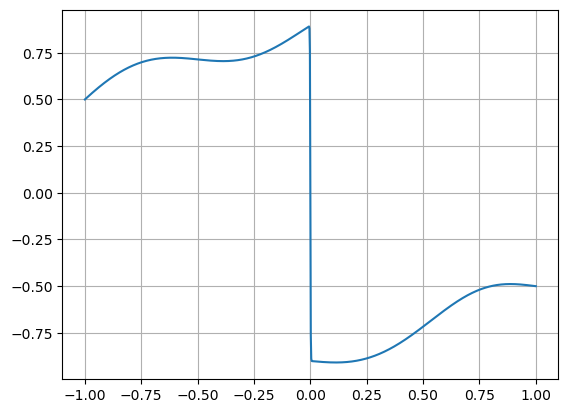

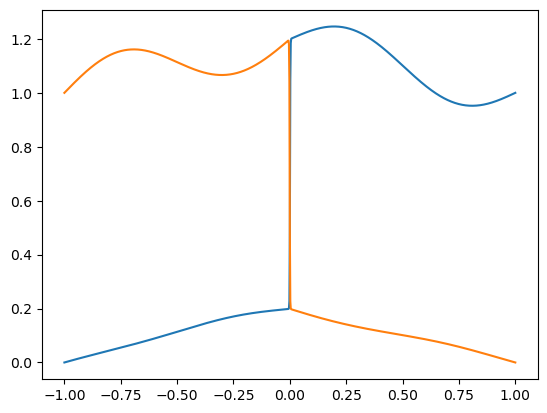

<Figure size 640x480 with 0 Axes>

In [320]:
pars2 = [0.001,100,-0.5]
#grid = makegrid(20,-1,1, 3*pars[0])
grid = makesimplegrid(1000,-1,1)
graph2, P, N= Alg2(grid, pars2, 5)
plt.plot(grid, graph2)
plt.grid()
plt.figure()

plt.plot(grid, P)
plt.plot(grid, N)
plt.figure()

In [306]:
def VA(vs, grid, parr, n):
    """
    Построение вольтамперной характеристики
    """
    psiprev = np.zeros(len(vs))
    rezs = np.zeros(len(vs))
    for i in range(len(vs)):
        if vs[i]>0:
            par = np.append(parr, vs[i-1])
            print(vs[i])
            Psi00 = psiprev -(vs[i]-vs[i-1])*grid
            par[2] = vs[i]
            Psi, P, N = vamod(grid, par, n, Psi00)
            psiprev = Psi
        else:
            par = np.append(parr, vs[i])
            Psi, P, N = Alg2(grid, par, n)
            psiprev= Psi
        plt.plot(grid[10:-10], P[10:-10], label = "P(x)")
        plt.plot(grid[10:-10], N[10:-10], label = "N(x)")
        plt.grid()
        plt.legend()

        plt.figure()
        rezs[i] =getcp(grid, Psi, vs[i])+getcn(grid, Psi, vs[i])
        
    return rezs

0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5


C:\Users\Серёжа\AppData\Local\Temp\ipykernel_14908\782011846.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


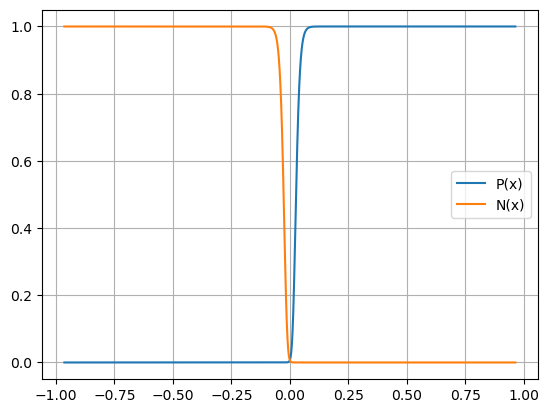

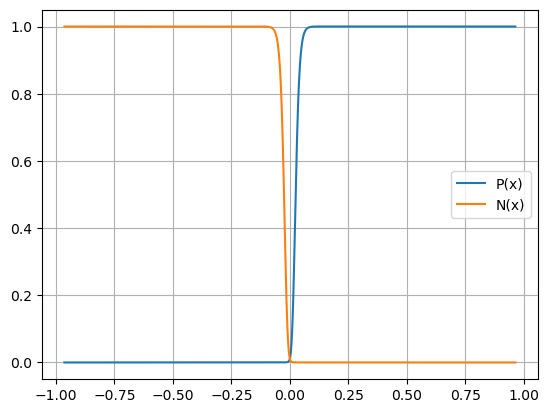

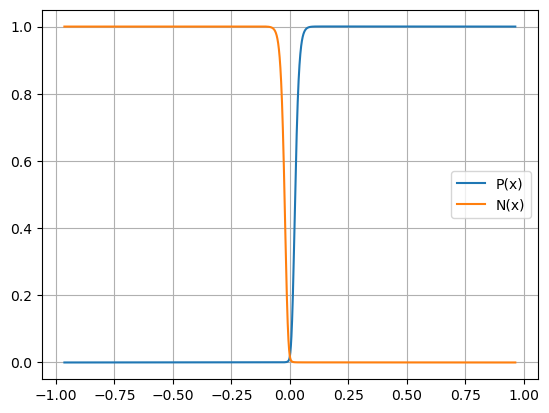

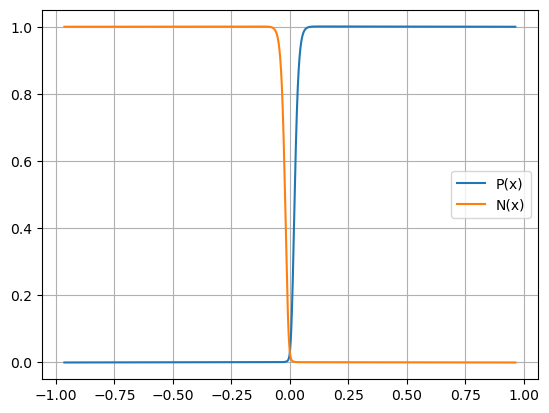

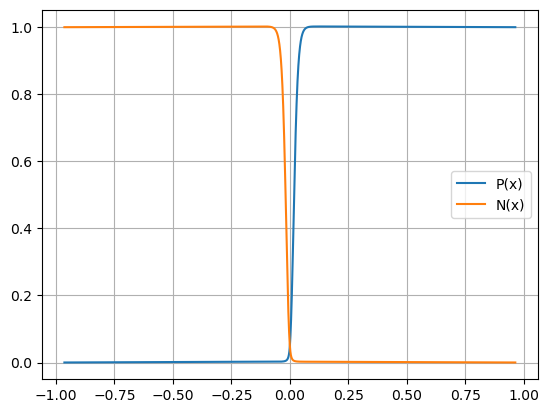

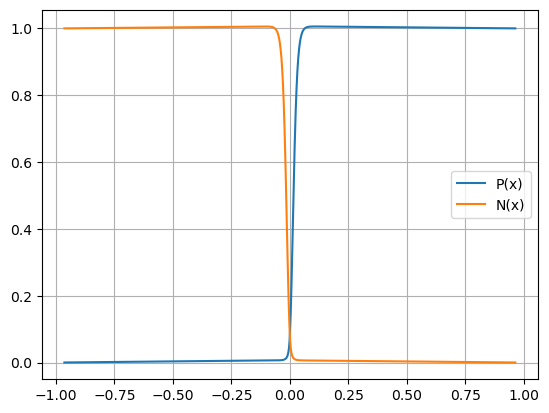

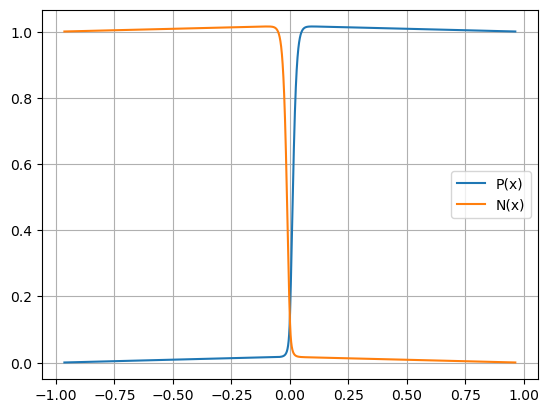

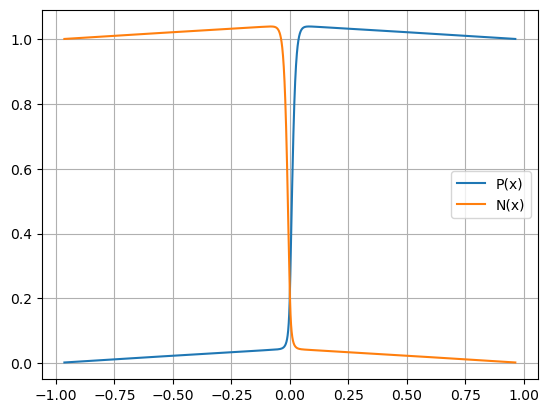

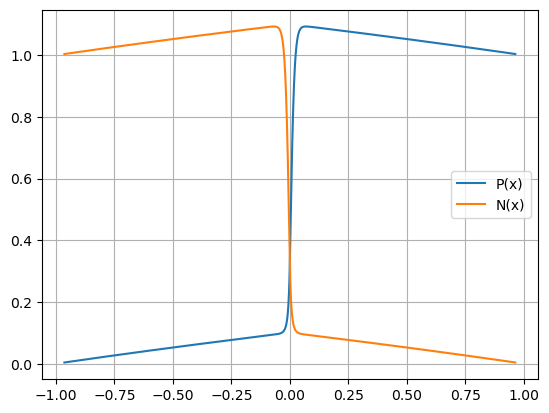

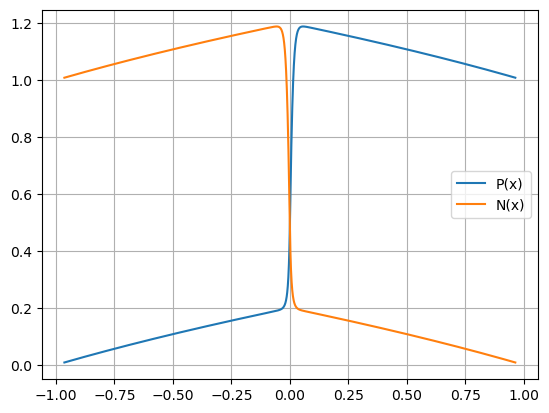

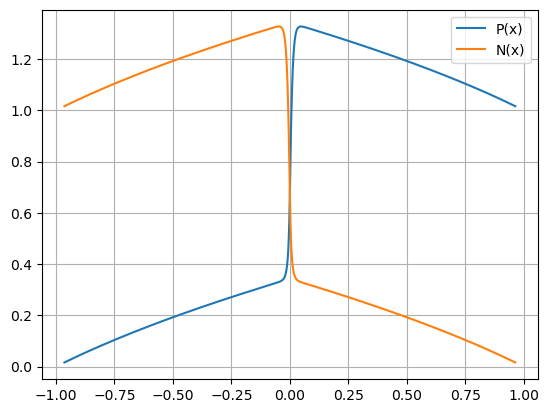

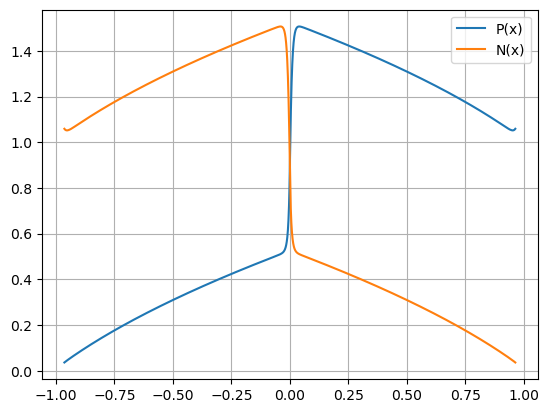

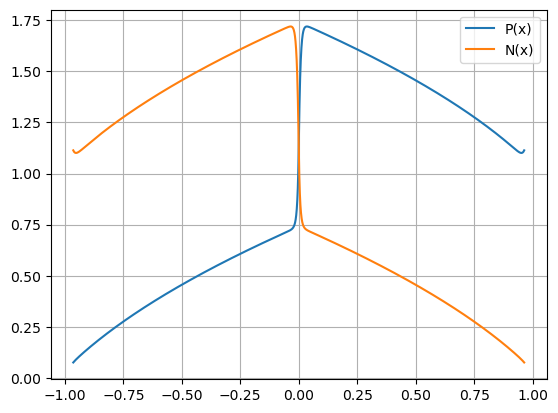

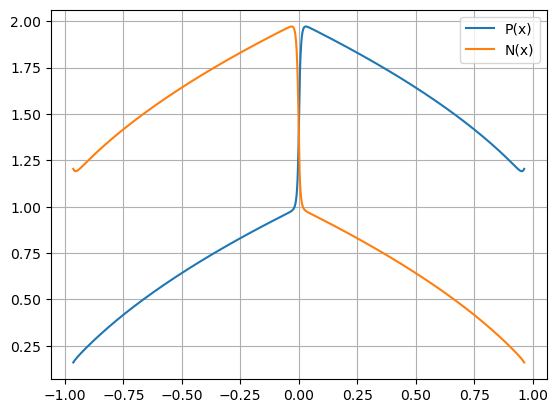

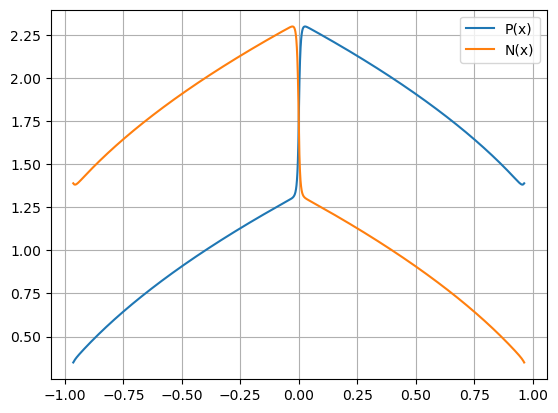

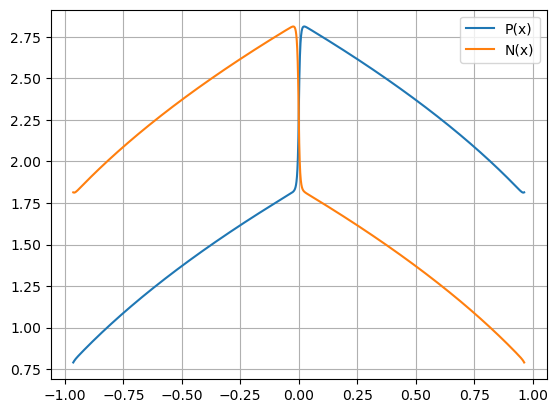

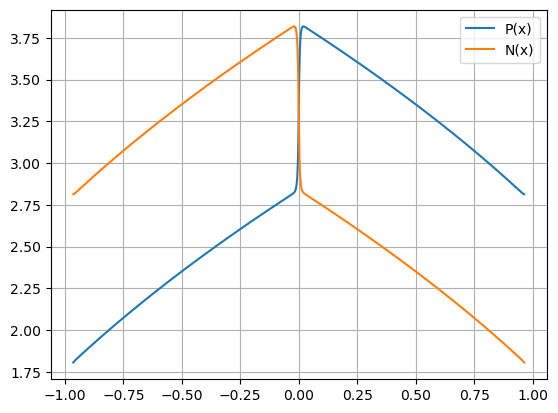

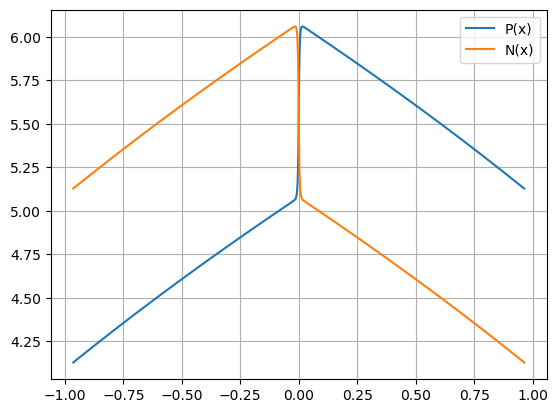

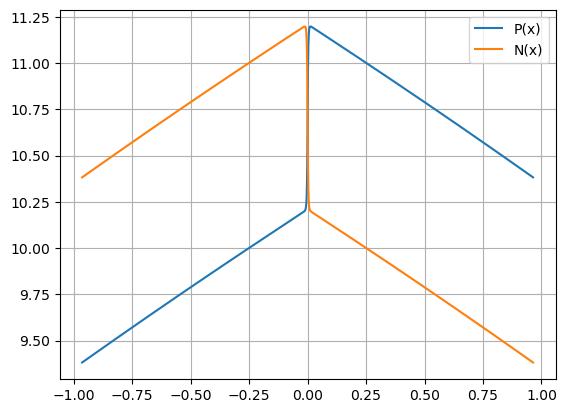

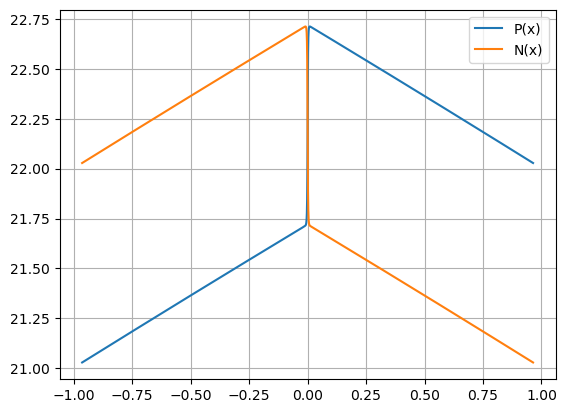

<Figure size 640x480 with 0 Axes>

In [307]:
grid = makegrid(1000,-1,1, 0.1)
vss = np.delete(np.arange(-5,5.01,0.5),20)
#print(vss)
r = VA(vss, grid, [0.01,100],5)

Text(0.5, 0, 'V')

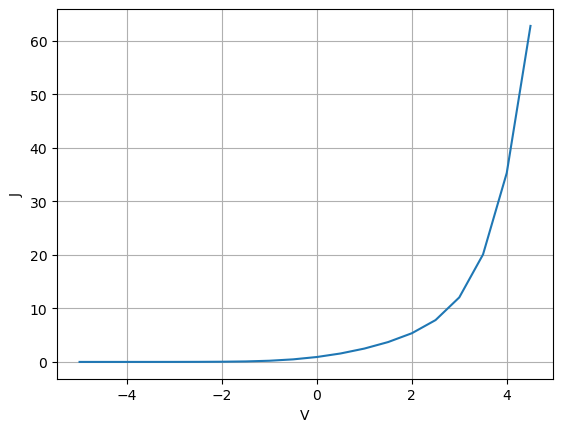

In [308]:
plt.plot(vss,r)
plt.grid()
plt.ylabel("J")
plt.xlabel("V")


In [118]:
# выржание для используемых интегралов
def getbf(grid, Psi):
    return integrate(grid, np.exp(Psi))
def getbg(grid, Psi):
    return integrate(grid, np.exp(-Psi))
def getaf(grid, Psi):
    return antiderivativeA(grid, np.exp(Psi))
def getag(grid, Psi):
    return antiderivativeB(grid, np.exp(-Psi))
def Ibf(grid, Psi):
    coefs = np.zeros(len(grid))
    coefs[0]=(np.exp(Psi[0]))*(grid[1]-grid[0])*0.5
    for i in range(1,len(grid)-1):
        coefs[i]=(np.exp(Psi[i]))*(grid[i+1]-grid[i-1])*0.5
    coefs[len(grid)-1] = (np.exp(Psi[len(grid)-1]))*(grid[len(grid)-1])*0.5
    return coefs

def Iaf(grid, Psi,n):
    coefs = np.zeros(len(grid))
    if(n!=0):
        coefs[0]=(np.exp(Psi[0]))*(grid[1]-grid[0])*0.5  
        for i in range(1,n):
            coefs[i]=(np.exp(Psi[i]))*(grid[i+1]-grid[i-1])*0.5
        coefs[n] = (np.exp(Psi[n]))*(grid[n]-grid[n-1])*0.5
    return coefs

def Ibg(grid, Psi):
    coefs = np.zeros(len(grid))
    for i in range(1,len(grid)-1):
        coefs[i]=(np.exp(-Psi[i]))*(grid[i+1]-grid[i-1])*0.5
    coefs[0]=(np.exp(-Psi[0]))*(grid[1]-grid[0])*0.5
    coefs[len(grid)-1] = (np.exp(-Psi[len(grid)-1]))*(grid[len(grid)-1]-grid[len(grid)-2])*0.5
    return coefs

def Iag(grid, Psi,n):
    coefs = np.zeros(len(grid))
    if (n !=len(grid)-1):
        coefs[n] = (np.exp(-Psi[n]))*(grid[n+1]-grid[n])*0.5     

        for i in range(n+1,len(grid)-1):
            coefs[i]=(np.exp(-Psi[i]))*(grid[i+1]-grid[i-1])*0.5

        coefs[len(grid)-1] = (np.exp(-Psi[len(grid)-1]))*(grid[len(grid)-1]-grid[len(grid)-2])*0.5      
    return coefs

In [125]:
#один шаг метода Ньютона-Канторовича
def Step3(grid, psi, dpsi, params, n):
    """
    Обращение оператора производной Фреше
    в задаче 3 (отсутствие рекмобинации)
    при использование алгоритма
    на основе метода Ньютона
    """
    eps = params[0]
    gamma = params[1]
    V = params[2]
    s = len(psi)
    F = np.empty(s-2)
    M = np.zeros((s-2,s-2), dtype = np.float64)
    fk = getffunc(grid, psi, V)
    gk = getgfunc(grid, psi,V)
    for i in range(1, s-1):
        F[i-1]= right2(grid[i], psi[i], dpsi[i], fk[i], gk[i], params)       
    af = getaf(grid, psi)
    ag = getag(grid, psi)
    bf = getbf(grid, psi)
    bg= getbg(grid, psi)  
    ibg = Ibg(grid, psi)
    ibf = Ibf(grid, psi)

    for i in range(1, s-1):
        iaf = Iaf(grid, psi, i)
        iag = Iag(grid, psi, i)  
        Df = np.exp(V)*np.exp(-psi[i])*(iaf/bf- ibf*af[i]/pow(bf,2))
        Dg = np.exp(V)*np.exp(psi[i])*(iag/bg-ag[i]*ibg/pow(bg,2))
        for j in range(1,s-1):
            M[i-1][j-1] += Df[j]+Dg[j]    
    for i in range(1, int(n/2)+1):
        args = ddstepmn(grid[i-1:i+2], 2)
        for j in range(0,3):
            if((i-2+j)>=0):
                M[i-1][i-2+j] = pow(eps, 2)* args[j]
        M[i-1][i-1] += leftlin(grid[i], psi[i], dpsi[i], fk[i], gk[i], params)
    for i in range(int(n/2) +1, s-(int(n/2)+1)):
        args = ddstepmn(grid[i-int(n/2):i+(int(n/2) +1)],int(n/2) +1)
        for j in range(n):
            M[i-1][j+i-(int(n/2)+1)] = args[j]* pow(eps,2)
        M[i-1][i-1] += leftlin(grid[i], psi[i], dpsi[i], fk[i], gk[i], params)
    M[0][s-3]=0
    for i in range(1, int(n/2)+1):
        args = ddstepmn(grid[s-1-(i+3):s-1-(i)], 2)
        for j in range(0,3):
            if((s-2-i+j-1)<=s-3):
                M[s-2-i][s-2-i+j-1] = pow(eps, 2)* args[j]
        M[s-2-i][s-2-i] += leftlin(grid[s-i-1], psi[s-i-1], dpsi[s-i-1], fk[s-i-1], gk[s-i-1], params)  
    temp = cgalg(M, F) 
    rez = np.append(0.0,temp)
    rez = np.append(rez, 0.0)
    return rez

In [313]:
def Alg3(params, grid, num):
    """
    Метод Ньютона-Канторовича
    в задаче 3 (отсутствие рекмобинации)
    """
    V = params[2]
    Psik = psi0func(grid, params)
    D2Psik = DDerivm(grid,Psik,  num)
    Hk = np.ones(len(grid))
    while(Check(Hk)):
        Hk = Step3(grid, Psik, D2Psik, params, num)
        print(np.amax(Hk))    
        Psik = Psik + Hk
        D2Psik = DDerivm(grid,Psik, num)    
    fk = getffunc(grid, Psik, V)
    gk = getgfunc(grid, Psik, V)
    fk[len(fk)-1]=1.0/np.exp(-V)   
    gk[0]=1.0/np.exp(-V)
    return Psik, fk*np.exp(-Psik), gk*np.exp(Psik)

0.9009258846167898
0.16321459757780923
0.011915016397998406
4.7178305405794256e-05
8.81929943820703e-09
3.0465354271165115e-12
2.915249261440374e-15


<Figure size 640x480 with 0 Axes>

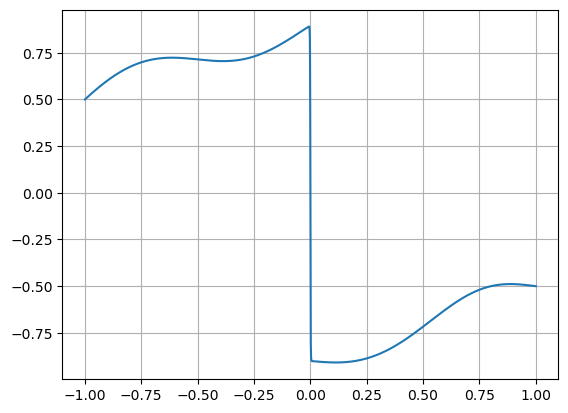

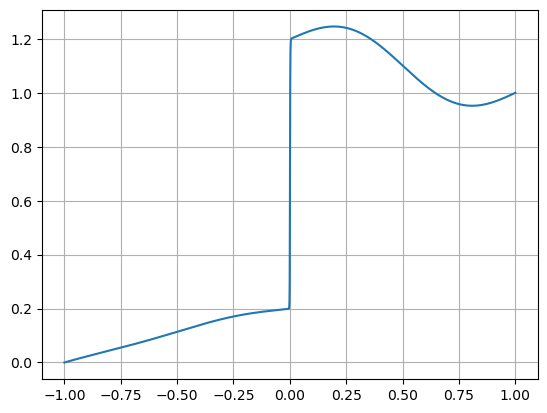

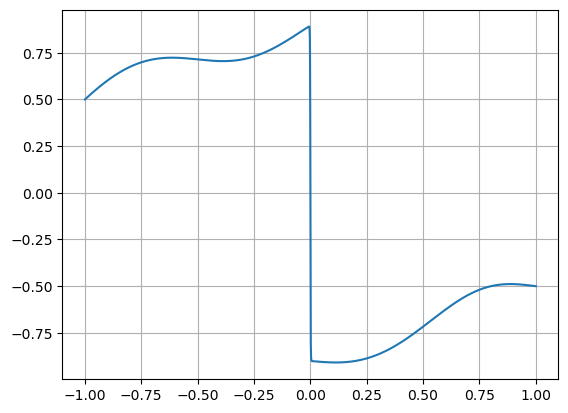

<Figure size 640x480 with 0 Axes>

In [316]:
pars = [0.001,100,-0.5]

grid = makegrid(1000,-1,1, 0.1)
#grid = makesimplegrid(1000,-1,1)
graph, p, n= Alg3(pars, grid, 5)
plt.plot(grid, graph)
plt.grid()

plt.figure()
plt.plot(grid, p)
plt.grid()

plt.figure()
plt.plot(grid, graph)
plt.grid()
plt.figure()
#getbf(grid,psi0func(grid,pars))